## Assignment 2: Face Reconitiion

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.datasets import fetch_lfw_people

In [4]:
"""
As an example of support vector machines in action, let's take a look at the facial recognition problem. 
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of 
various public figures. A fetcher for the dataset is built into Scikit-Learn:
"""

faces = fetch_lfw_people(min_faces_per_person=60)

print(f'Target Names: {faces.target_names}\n\nImages Shape: {faces.images.shape}')

Target Names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']

Images Shape: (1348, 62, 47)


In [10]:
"""
Let's plot a few of these faces to see what we're working with:

Each image contains [62×47] or nearly 3,000 pixels. We could proceed by simply using each pixel value as 
a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful 
features; here we will use a principal component analysis (we will learn about PCA later) to extract 150 
fundamental components to feed into our support vector machine classifier. We can do this most 
straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

"""

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

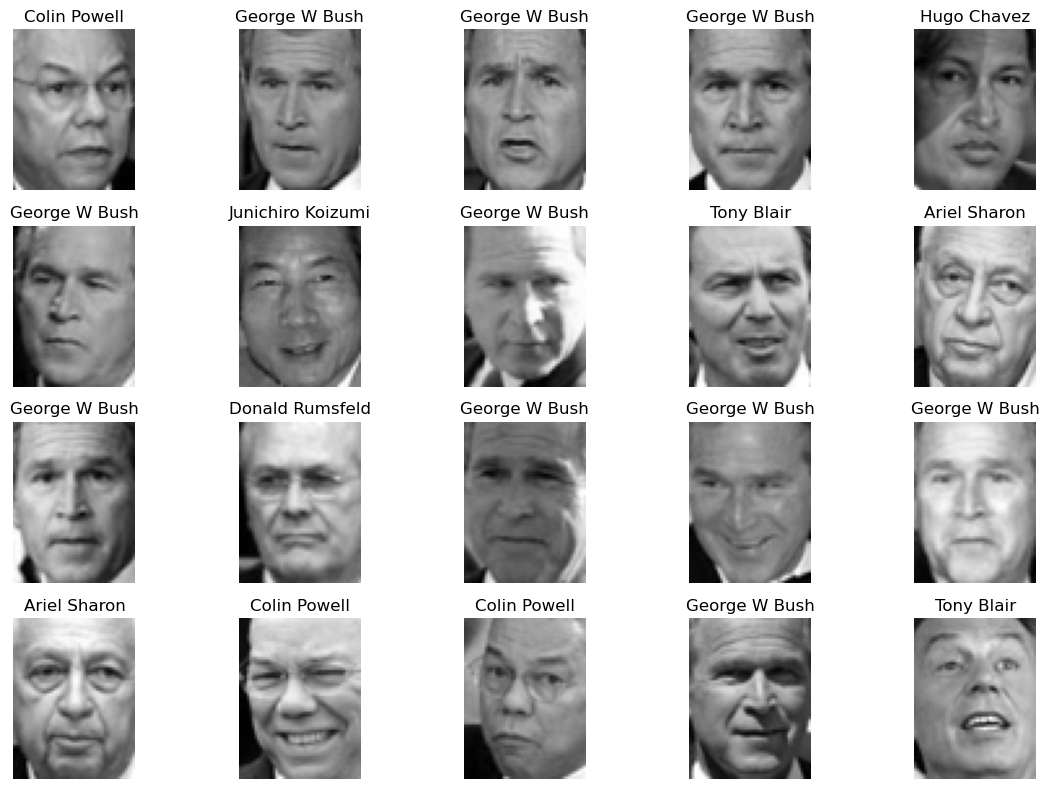

In [7]:
# Get the images, target labels, and target names
images = faces.images
target_labels = faces.target
target_names = faces.target_names

# Plot a grid of images with their respective target names (20 images)
fig, axes = plt.subplots(4, 5, figsize=(12, 8))

# Iterate over the grid and plot the images with names
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(target_names[target_labels[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Extract the images (X) and labels (y)
X = faces.data  # Flattened data (1348, 62 * 47 = 2914 features per image)
y = faces.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a PCA object to reduce dimensionality to 150 components
pca = PCA(n_components=150, whiten=True, random_state=42)

# Create an SVM classifier
svc = SVC(kernel='rbf', class_weight='balanced')

# Combine PCA and SVM into a pipeline
model = make_pipeline(pca, svc)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Print classification report to evaluate the model
print(classification_report(y_test, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.73      0.85        15
     Colin Powell       0.69      0.96      0.80        68
  Donald Rumsfeld       0.89      0.77      0.83        31
    George W Bush       0.90      0.87      0.88       126
Gerhard Schroeder       0.89      0.70      0.78        23
      Hugo Chavez       1.00      0.65      0.79        20
Junichiro Koizumi       1.00      0.92      0.96        12
       Tony Blair       0.86      0.86      0.86        42

         accuracy                           0.85       337
        macro avg       0.90      0.81      0.84       337
     weighted avg       0.87      0.85      0.85       337



In [11]:
"""
Finally, we can use a grid search cross-validation to explore combinations of parameters. 
Here we will adjust C (which controls the margin hardness) and gamma (which controls the size 
of the radial basis function kernel), and determine the best model:

The optimal values fall toward the middle of our grid; if they fell at the edges, we would want 
to expand the grid to make sure we have found the true optimum.

"""

# Define the parameter grid to search over
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1]
}


# Create a GridSearchCV object to search for the best combination of parameters
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search model to the training data
grid.fit(X_train, y_train)

# Print the best parameters found by the grid search
print(f"Best parameters found: {grid.best_params_}")

# Use the best model to predict on the test set
y_pred = grid.best_estimator_.predict(X_test)

# Print the classification report to evaluate the model
print(classification_report(y_test, y_pred, target_names=faces.target_names))

Best parameters found: {'svc__C': 1, 'svc__gamma': 0.001}
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.87      0.72        15
     Colin Powell       0.87      0.85      0.86        68
  Donald Rumsfeld       0.83      0.81      0.82        31
    George W Bush       0.94      0.81      0.87       126
Gerhard Schroeder       0.70      0.83      0.76        23
      Hugo Chavez       0.80      0.80      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.78      0.95      0.86        42

         accuracy                           0.85       337
        macro avg       0.81      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



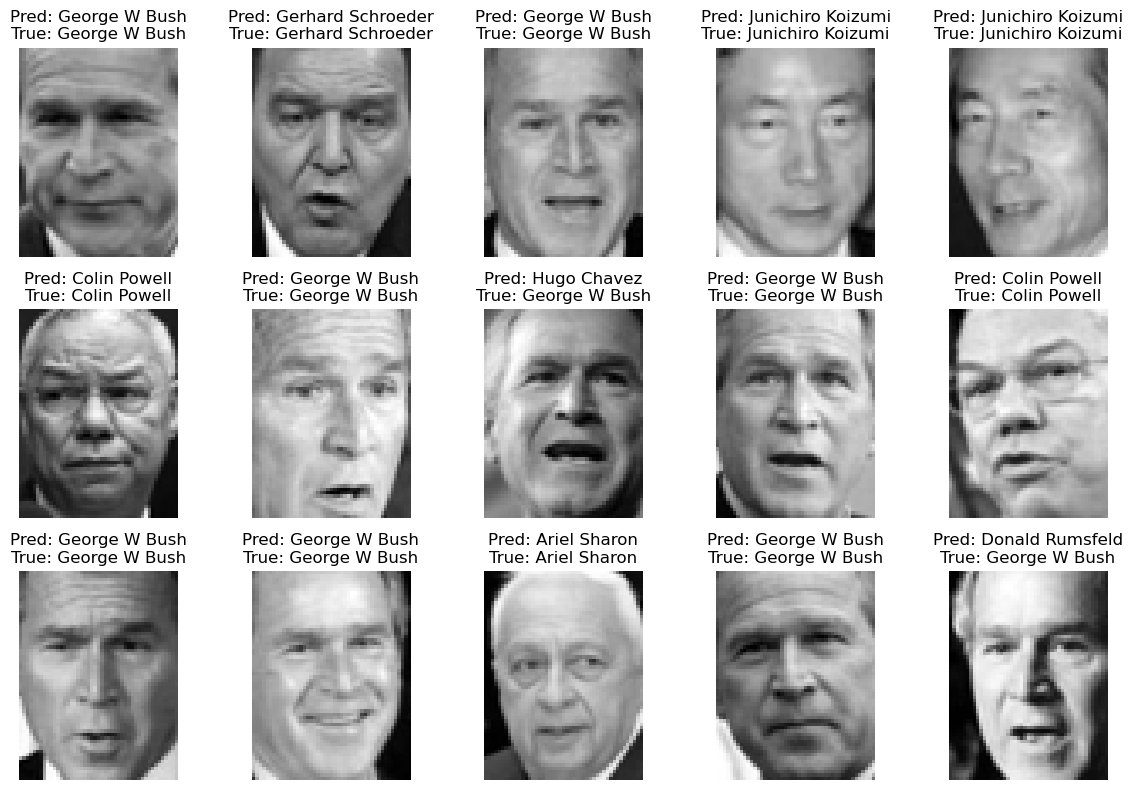

In [12]:
"""
Now with this cross-validated model, we can predict the labels for the test data, 
which the model has not yet seen:

Let's take a look at a few of the test images along with their predicted values:
"""

# Get the predicted labels for the test set
y_pred = grid.best_estimator_.predict(X_test)

# Select the first 15 test images and their true/predicted labels
fig, axes = plt.subplots(3, 5, figsize=(12, 8))

# Plot the images along with the predicted and actual labels
for i, ax in enumerate(axes.ravel()[:15]):
    ax.imshow(X_test[i].reshape(62, 47), cmap='gray')  # Reshape the flattened image back to its original shape
    ax.set_title(f"Pred: {faces.target_names[y_pred[i]]}\nTrue: {faces.target_names[y_test[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
"""
Out of this small sample, our optimal estimator mislabeled only a single face 
(Bush’s face in the bottom row was mislabeled as Blair). We can get a better sense 
of our estimator's performance using the classification report, which lists recovery 
statistics label by label:

"""
# Print the classification report to evaluate the model
print(classification_report(y_test, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.87      0.72        15
     Colin Powell       0.87      0.85      0.86        68
  Donald Rumsfeld       0.83      0.81      0.82        31
    George W Bush       0.94      0.81      0.87       126
Gerhard Schroeder       0.70      0.83      0.76        23
      Hugo Chavez       0.80      0.80      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.78      0.95      0.86        42

         accuracy                           0.85       337
        macro avg       0.81      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



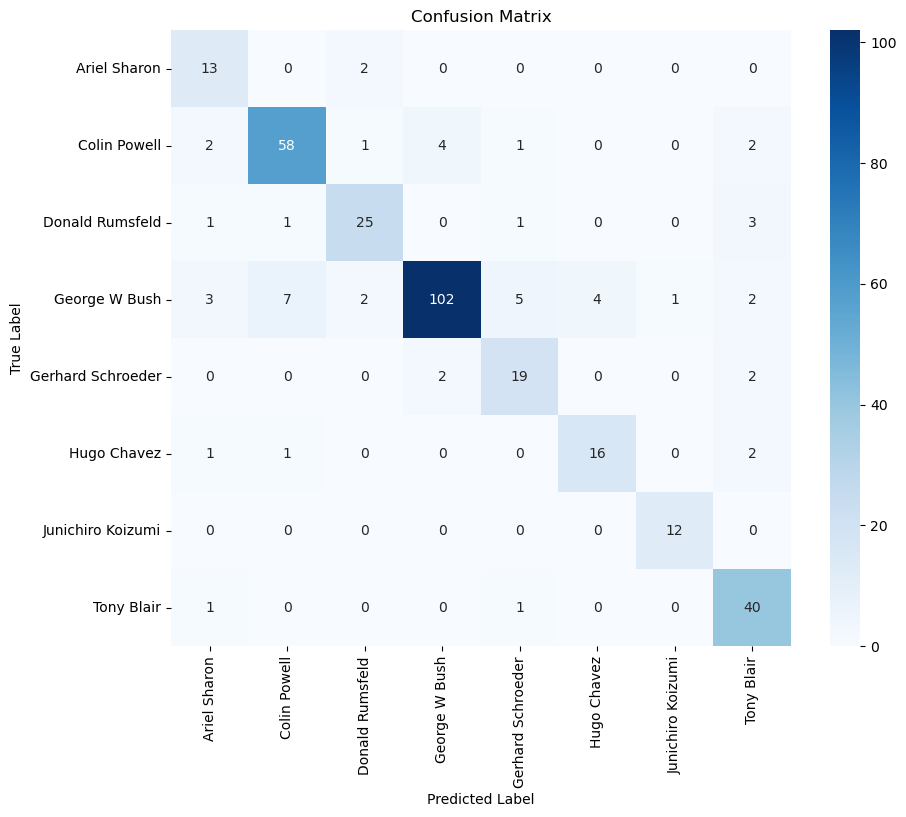

In [14]:
"""
We might also display the confusion matrix between these classes:

This helps us get a sense of which labels are likely to be confused by the estimator.
"""
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=faces.target_names, 
            yticklabels=faces.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()